# Formação Cientista de Dados
### Projeto com Feedback 4
### Prevendo Customer Churn em Operadoras de Telecom

### Gabriel Quaiotti - Abr 2020

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, você deve prever o Customer Churn em uma Operadora de Telecom.

Os datasets de treino e de teste serão fornecidos para você em anexo a este projeto. Seu trabalho é criar um modelo de aprendizagem de máquina que possa prever se um cliente pode ou não cancelar seu plano e qual a probabilidade
de isso ocorrer. O cabeçalho do dataset é uma descrição do tipo de informação em cada coluna.

Usando linguagem Python, recomendamos você criar um modelo de Regressão Logística, para extrair a informação se um cliente vai cancelar seu plano (Sim ou Não) e a probabilidade de uma opção ou outra.

In [122]:
# Libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.functions import stddev
from pyspark.sql.functions import mean

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

import matplotlib.pyplot as plt

In [123]:
# Spark Session - usado para trabalhar com o Spark
spSession = SparkSession.builder.master("local").appName("DSA-TELECOM-SCALE").getOrCreate()

# SCALE (balanced by majority class)

In [124]:
# Read train dataset
balanced_rdd = sc.textFile('../dataset/df_balanced_1.csv')

In [125]:
# Remove header and split by ','
header = balanced_rdd.first()
balanced_rdd2 = balanced_rdd.filter(lambda line: line != header).map(lambda line: line.split(","))

In [126]:
# Define the dataFrame columns
balanced_fields = [StructField("id", StringType(), True), 
     StructField("account_length", StringType(), True),
     StructField("international_plan", StringType(), True),
     StructField("voice_mail_plan", StringType(), True),
     StructField("number_vmail_messages", StringType(), True),
     StructField("total_day_minutes", StringType(), True),
     StructField("total_day_calls", StringType(), True),
     StructField("total_day_charge", StringType(), True),
     StructField("total_eve_minutes", StringType(), True),
     StructField("total_eve_calls", StringType(), True),
     StructField("total_eve_charge", StringType(), True),
     StructField("total_night_minutes", StringType(), True),
     StructField("total_night_calls", StringType(), True),
     StructField("total_night_charge", StringType(), True),
     StructField("total_intl_minutes", StringType(), True),
     StructField("total_intl_calls", StringType(), True),
     StructField("total_intl_charge", StringType(), True),
     StructField("number_customer_service_calls", StringType(), True),
     StructField("churn", StringType(), True),
     StructField("state_id", StringType(), True),
     StructField("area_code_id", StringType(), True)]

In [127]:
# Define the dataFrame schema
balanced_schema = StructType( balanced_fields )

In [128]:
# Create dataFrame
balanced_ds = spSession.createDataFrame(balanced_rdd2, balanced_schema)

In [129]:
balanced_ds = balanced_ds.withColumn('id', col('id').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('account_length', col('account_length').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('international_plan', col('international_plan').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('voice_mail_plan', col('voice_mail_plan').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('number_vmail_messages', col('number_vmail_messages').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_minutes', col('total_day_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_calls', col('total_day_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_charge', col('total_day_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_minutes', col('total_eve_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_calls', col('total_eve_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_charge', col('total_eve_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_minutes', col('total_night_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_calls', col('total_night_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_charge', col('total_night_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_minutes', col('total_intl_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_calls', col('total_intl_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_charge', col('total_intl_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('number_customer_service_calls', col('number_customer_service_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('churn', col('churn').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('state_id', col('state_id').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('area_code_id', col('area_code_id').cast(DoubleType()))

In [130]:
balanced_ds

DataFrame[id: double, account_length: double, international_plan: double, voice_mail_plan: double, number_vmail_messages: double, total_day_minutes: double, total_day_calls: double, total_day_charge: double, total_eve_minutes: double, total_eve_calls: double, total_eve_charge: double, total_night_minutes: double, total_night_calls: double, total_night_charge: double, total_intl_minutes: double, total_intl_calls: double, total_intl_charge: double, number_customer_service_calls: double, churn: double, state_id: double, area_code_id: double]

In [131]:
balanced_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,1.0,128.0,0.0,1.0,25.0,265.1,110.0,45.07,197.4,99.0,...,244.7,91.0,11.01,10.0,9.0,2.70,1.0,0.0,17.0,0.0
1,2.0,107.0,0.0,1.0,26.0,161.6,123.0,27.47,195.5,103.0,...,254.4,103.0,11.45,13.7,9.0,3.70,1.0,0.0,5.0,0.0
2,3.0,137.0,0.0,0.0,0.0,243.4,114.0,41.38,121.2,110.0,...,162.6,104.0,7.32,12.2,25.0,3.29,0.0,0.0,19.0,0.0
3,4.0,84.0,1.0,0.0,0.0,299.4,71.0,50.90,61.9,88.0,...,196.9,89.0,8.86,6.6,49.0,1.78,4.0,0.0,5.0,2.0
4,5.0,75.0,1.0,0.0,0.0,166.7,113.0,28.34,148.3,122.0,...,186.9,121.0,8.41,10.1,9.0,2.73,9.0,0.0,34.0,0.0


In [132]:
# Get the columns to scale (predictors)
columns_to_scale = balanced_ds.drop('id', 'churn').columns

# Transform values to vector (requirement)
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]

# Scale column values
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

# Execute the pipeline (Vector + Scale)
pipeline = Pipeline(stages=assemblers + scalers)

# Fit the scale model
scalerModel = pipeline.fit(balanced_ds)

# Transform as dataFrame
scaled_ds = scalerModel.transform(balanced_ds)

In [133]:
scaled_ds.printSchema() 

root
 |-- id: double (nullable = true)
 |-- account_length: double (nullable = true)
 |-- international_plan: double (nullable = true)
 |-- voice_mail_plan: double (nullable = true)
 |-- number_vmail_messages: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: double (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: double (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: double (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: double (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: double (nullable = true)
 |-- churn: double (nullable = true)
 |-- state_id: double (nullable = true)
 |-- area_code_id: double (nullable = true

In [134]:
# Transform vector to double
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

# Get scaled values
for i in columns_to_scale:
    # Transform original column
    scaled_ds = scaled_ds.withColumn(i, unlist(i + "_scaled"))
    # Drop _vec column
    scaled_ds = scaled_ds.drop(i + "_vec")
    # Drop _scaled column
    scaled_ds = scaled_ds.drop(i + "_scaled")

In [135]:
scaled_ds.toPandas().columns

Index(['id', 'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn',
       'state_id', 'area_code_id'],
      dtype='object')

In [136]:
scaled_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,1.0,0.524793,0.0,1.0,0.490196,0.755701,0.666667,0.755701,0.542755,0.582353,...,0.595750,0.408451,0.595935,0.500,0.0225,0.500000,0.012346,0.0,0.34,0.0
1,2.0,0.438017,0.0,1.0,0.509804,0.460661,0.745455,0.460597,0.537531,0.605882,...,0.621840,0.492958,0.622236,0.685,0.0225,0.685185,0.012346,0.0,0.10,0.0
2,3.0,0.561983,0.0,0.0,0.000000,0.693843,0.690909,0.693830,0.333242,0.647059,...,0.374933,0.500000,0.375374,0.610,0.0625,0.609259,0.000000,0.0,0.38,0.0
3,4.0,0.342975,1.0,0.0,0.000000,0.853478,0.430303,0.853454,0.170195,0.517647,...,0.467187,0.394366,0.467424,0.330,0.1225,0.329630,0.049383,0.0,0.10,1.0
4,5.0,0.305785,1.0,0.0,0.000000,0.475200,0.684848,0.475184,0.407754,0.717647,...,0.440290,0.619718,0.440526,0.505,0.0225,0.505556,0.111111,0.0,0.68,0.0


In [137]:
scaled_ds.toPandas().describe()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
count,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,...,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000,5711.000000
mean,1706.301173,0.415127,0.170548,0.229557,0.134326,0.544262,0.610729,0.544235,0.564418,0.590047,...,0.481989,0.475086,0.482263,0.522788,0.061323,0.522886,0.072691,0.500963,0.447561,0.378305
std,963.027410,0.163072,0.376147,0.420585,0.255939,0.176718,0.125525,0.176706,0.140703,0.116235,...,0.131811,0.140331,0.131824,0.140681,0.079576,0.140685,0.111030,0.500043,0.285225,0.412782
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,874.500000,0.305785,0.000000,0.000000,0.000000,0.418472,0.527273,0.418511,0.467143,0.511765,...,0.391877,0.373239,0.392110,0.435000,0.022500,0.435185,0.012346,0.000000,0.200000,0.000000
50%,1746.000000,0.413223,0.000000,0.000000,0.000000,0.539054,0.618182,0.539068,0.565576,0.594118,...,0.483055,0.471831,0.483562,0.525000,0.040000,0.525926,0.012346,1.000000,0.420000,0.500000
75%,2543.000000,0.520661,0.000000,0.000000,0.000000,0.675314,0.696970,0.675218,0.660159,0.670588,...,0.573292,0.577465,0.573521,0.615000,0.076250,0.614815,0.111111,1.000000,0.680000,0.500000
max,3333.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
# Save transformed dataset
scaled_ds.toPandas().to_csv('../dataset/df_scaled_1.csv', index=False)

In [139]:
scaled_ds_1 = scaled_ds

# SCALE (balanced by minority class)

In [140]:
# Read train dataset
balanced_rdd = sc.textFile('../dataset/df_balanced_0.csv')

In [141]:
# Remove header and split by ','
header = balanced_rdd.first()
balanced_rdd2 = balanced_rdd.filter(lambda line: line != header).map(lambda line: line.split(","))

In [142]:
# Define the dataFrame columns
balanced_fields = [StructField("id", StringType(), True), 
     StructField("account_length", StringType(), True),
     StructField("international_plan", StringType(), True),
     StructField("voice_mail_plan", StringType(), True),
     StructField("number_vmail_messages", StringType(), True),
     StructField("total_day_minutes", StringType(), True),
     StructField("total_day_calls", StringType(), True),
     StructField("total_day_charge", StringType(), True),
     StructField("total_eve_minutes", StringType(), True),
     StructField("total_eve_calls", StringType(), True),
     StructField("total_eve_charge", StringType(), True),
     StructField("total_night_minutes", StringType(), True),
     StructField("total_night_calls", StringType(), True),
     StructField("total_night_charge", StringType(), True),
     StructField("total_intl_minutes", StringType(), True),
     StructField("total_intl_calls", StringType(), True),
     StructField("total_intl_charge", StringType(), True),
     StructField("number_customer_service_calls", StringType(), True),
     StructField("churn", StringType(), True),
     StructField("state_id", StringType(), True),
     StructField("area_code_id", StringType(), True)]

In [143]:
# Define the dataFrame schema
balanced_schema = StructType( balanced_fields )

In [144]:
# Create dataFrame
balanced_ds = spSession.createDataFrame(balanced_rdd2, balanced_schema)

In [145]:
balanced_ds = balanced_ds.withColumn('id', col('id').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('account_length', col('account_length').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('international_plan', col('international_plan').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('voice_mail_plan', col('voice_mail_plan').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('number_vmail_messages', col('number_vmail_messages').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_minutes', col('total_day_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_calls', col('total_day_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_day_charge', col('total_day_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_minutes', col('total_eve_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_calls', col('total_eve_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_eve_charge', col('total_eve_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_minutes', col('total_night_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_calls', col('total_night_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_night_charge', col('total_night_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_minutes', col('total_intl_minutes').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_calls', col('total_intl_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('total_intl_charge', col('total_intl_charge').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('number_customer_service_calls', col('number_customer_service_calls').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('churn', col('churn').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('state_id', col('state_id').cast(DoubleType()))
balanced_ds = balanced_ds.withColumn('area_code_id', col('area_code_id').cast(DoubleType()))

In [146]:
balanced_ds

DataFrame[id: double, account_length: double, international_plan: double, voice_mail_plan: double, number_vmail_messages: double, total_day_minutes: double, total_day_calls: double, total_day_charge: double, total_eve_minutes: double, total_eve_calls: double, total_eve_charge: double, total_night_minutes: double, total_night_calls: double, total_night_charge: double, total_intl_minutes: double, total_intl_calls: double, total_intl_charge: double, number_customer_service_calls: double, churn: double, state_id: double, area_code_id: double]

In [147]:
balanced_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,10.0,141.0,1.0,1.0,37.0,258.6,84.0,43.96,222.0,111.0,...,326.4,97.0,14.69,11.2,25.0,3.02,0.0,0.0,0.0,0.0
1,15.0,62.0,0.0,0.0,0.0,120.7,70.0,20.52,307.2,76.0,...,203.0,99.0,9.14,13.1,36.0,3.54,16.0,0.0,49.0,0.0
2,23.0,130.0,0.0,0.0,0.0,183.0,112.0,31.11,72.9,99.0,...,181.8,78.0,8.18,9.5,361.0,2.57,0.0,0.0,27.0,0.0
3,39.0,136.0,1.0,1.0,33.0,203.9,106.0,34.66,187.6,99.0,...,101.7,107.0,4.58,10.5,36.0,2.84,9.0,0.0,46.0,0.0
4,45.0,64.0,0.0,0.0,0.0,154.0,67.0,26.18,225.8,118.0,...,265.3,86.0,11.94,3.5,9.0,0.95,1.0,0.0,4.0,1.0


In [148]:
# Get the columns to scale (predictors)
columns_to_scale = balanced_ds.drop('id', 'churn').columns

# Transform values to vector (requirement)
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]

# Scale column values
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

# Execute the pipeline (Vector + Scale)
pipeline = Pipeline(stages=assemblers + scalers)

# Fit the scale model
scalerModel = pipeline.fit(balanced_ds)

# Transform as dataFrame
scaled_ds = scalerModel.transform(balanced_ds)

In [149]:
scaled_ds.printSchema() 

root
 |-- id: double (nullable = true)
 |-- account_length: double (nullable = true)
 |-- international_plan: double (nullable = true)
 |-- voice_mail_plan: double (nullable = true)
 |-- number_vmail_messages: double (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: double (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: double (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: double (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: double (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: double (nullable = true)
 |-- churn: double (nullable = true)
 |-- state_id: double (nullable = true)
 |-- area_code_id: double (nullable = true

In [150]:
# Transform vector to double
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

# Get scaled values
for i in columns_to_scale:
    # Transform original column
    scaled_ds = scaled_ds.withColumn(i, unlist(i + "_scaled"))
    # Drop _vec column
    scaled_ds = scaled_ds.drop(i + "_vec")
    # Drop _scaled column
    scaled_ds = scaled_ds.drop(i + "_scaled")

In [151]:
scaled_ds.toPandas().columns

Index(['id', 'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn',
       'state_id', 'area_code_id'],
      dtype='object')

In [152]:
scaled_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,10.0,0.625000,1.0,1.0,0.770833,0.737172,0.509091,0.737089,0.556911,0.564885,...,0.907317,0.500000,0.907514,0.560,0.0625,0.559259,0.000000,0.0,0.00,0.0
1,15.0,0.272321,0.0,0.0,0.000000,0.344071,0.424242,0.344064,0.823327,0.297710,...,0.506016,0.516393,0.506503,0.655,0.0900,0.655556,0.197531,0.0,0.98,0.0
2,23.0,0.575893,0.0,0.0,0.000000,0.521665,0.678788,0.521630,0.090682,0.473282,...,0.437073,0.344262,0.437139,0.475,0.9025,0.475926,0.000000,0.0,0.54,0.0
3,39.0,0.602679,1.0,1.0,0.687500,0.581243,0.642424,0.581154,0.449343,0.473282,...,0.176585,0.581967,0.177023,0.525,0.0900,0.525926,0.111111,0.0,0.92,0.0
4,45.0,0.281250,0.0,0.0,0.000000,0.438997,0.406061,0.438967,0.568793,0.618321,...,0.708618,0.409836,0.708815,0.175,0.0225,0.175926,0.012346,0.0,0.08,0.5


In [153]:
scaled_ds.toPandas().describe()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000
mean,1707.154629,0.452723,0.170905,0.227874,0.140980,0.546667,0.608909,0.546640,0.506992,0.483634,...,0.503901,0.523498,0.504035,0.518215,0.065148,0.518323,0.074677,0.491353,0.445575,0.384537
std,958.196522,0.177207,0.376618,0.419674,0.269618,0.174825,0.124061,0.174813,0.160098,0.153222,...,0.160243,0.160240,0.160225,0.143423,0.088344,0.143419,0.112914,0.500180,0.284687,0.415025
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,897.500000,0.334821,0.000000,0.000000,0.000000,0.422463,0.533333,0.422368,0.397749,0.381679,...,0.393984,0.409836,0.394147,0.430000,0.022500,0.429630,0.012346,0.000000,0.200000,0.000000
50%,1753.000000,0.446429,0.000000,0.000000,0.000000,0.540194,0.606061,0.540241,0.510944,0.488550,...,0.508293,0.524590,0.508671,0.520000,0.040000,0.520370,0.012346,0.000000,0.420000,0.500000
75%,2535.500000,0.564732,0.000000,0.000000,0.000000,0.675029,0.690909,0.675050,0.615228,0.587786,...,0.617561,0.631148,0.617775,0.615000,0.090000,0.614815,0.111111,1.000000,0.680000,1.000000
max,3333.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
# Save transformed dataset
scaled_ds.toPandas().to_csv('../dataset/df_scaled_0.csv', index=False)

# STANDARTIZE

### Scaled dataset dit not present good acurracy on test. I will try to standartize the predictor columns.

In [155]:
# Get the columns to scale (predictors)
columns_to_standard = scaled_ds.drop('id', 'churn').columns
# Got the best results using the scaled dataset based on minority class balancing
# standard_ds = balanced_ds
# standard_ds = scaled_ds_1
standard_ds = scaled_ds
columns_to_standard

['account_length',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'state_id',
 'area_code_id']

In [156]:
standard_ds.toPandas().head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_id,area_code_id
0,10.0,0.625000,1.0,1.0,0.770833,0.737172,0.509091,0.737089,0.556911,0.564885,...,0.907317,0.500000,0.907514,0.560,0.0625,0.559259,0.000000,0.0,0.00,0.0
1,15.0,0.272321,0.0,0.0,0.000000,0.344071,0.424242,0.344064,0.823327,0.297710,...,0.506016,0.516393,0.506503,0.655,0.0900,0.655556,0.197531,0.0,0.98,0.0
2,23.0,0.575893,0.0,0.0,0.000000,0.521665,0.678788,0.521630,0.090682,0.473282,...,0.437073,0.344262,0.437139,0.475,0.9025,0.475926,0.000000,0.0,0.54,0.0
3,39.0,0.602679,1.0,1.0,0.687500,0.581243,0.642424,0.581154,0.449343,0.473282,...,0.176585,0.581967,0.177023,0.525,0.0900,0.525926,0.111111,0.0,0.92,0.0
4,45.0,0.281250,0.0,0.0,0.000000,0.438997,0.406061,0.438967,0.568793,0.618321,...,0.708618,0.409836,0.708815,0.175,0.0225,0.175926,0.012346,0.0,0.08,0.5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002280BDFACF8>]],
      dtype=object)

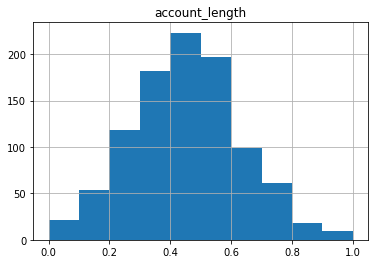

In [157]:
# Plot example
standard_ds.select('account_length').toPandas().hist()

In [158]:
# Apply standartization formula to all feature columns
for i in columns_to_standard:
    # Mean
    m = standard_ds.select(mean(i).alias('mean')).collect()
    # Standard Deviation
    s = standard_ds.select(stddev(i).alias('std')).collect()
    # Formula
    standard_ds = standard_ds.withColumn(i, (col(i) - m[0]['mean']) / s[0]['std'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022820BFB2E8>]],
      dtype=object)

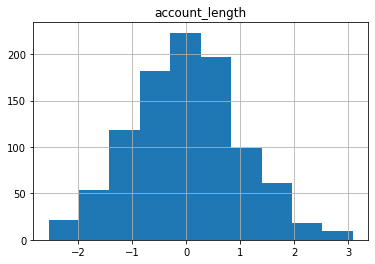

In [159]:
standard_ds.select('account_length').toPandas().hist()

In [160]:
# Save transformed dataset
standard_ds.toPandas().to_csv('../dataset/df_standard.csv', index=False)